SPECTRAL ANALYSIS OF RBM

Daniele Vanzan 880054

This project investigates how a Restricted Boltzmann Machine (RBM) learns to represent image data by analyzing the spectral properties of its weight matrix during training. In particular, we use Singular Value Decomposition (SVD) to track how the most significant singular values and singular vectors evolve over time, providing insight into how the hidden layer organizes the input distribution.

Several key plots are used to monitor learning dynamics:

Training loss and test accuracy over epochs to assess performance.

Top-5 singular values to observe dominant weight directions.

Explained variance ratios to quantify how much of the input structure is captured by top components.

Cosine similarity of top singular vectors to measure the stability of learned directions across epochs.

Cosine similarity of bias vectors to track changes in hidden and visible biases.

To explore how representational capacity affects spectral learning, we analyze three RBMs with different hidden layer sizes: 10, 100, and 1000 units. This stratification highlights how model complexity influences the spectral dynamics and feature extraction process.

This section analyzes the eigenvalue distribution of the weight covariance matrix across training epochs. We compare the empirical spectrum to:

The Marchenko–Pastur (MP) distribution, modeling random matrices

An exponential distribution, modeling unstructured decay

At selected epochs, we plot the spectrum, fit both models, and compute their RMSE. Outlier eigenvalues beyond the MP bounds signal emerging structure. A final plot tracks how well each fit explains the data during training.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score

# -------------------------------
# RBM with classification module
# -------------------------------
class RBM(nn.Module):
    def __init__(self, n_visible, n_hidden):
        super().__init__()
        self.W = nn.Parameter(torch.randn(n_hidden, n_visible) * 0.5)
        self.v_bias = nn.Parameter(torch.zeros(n_visible))
        self.h_bias = nn.Parameter(torch.zeros(n_hidden))
        self.classifier = nn.Linear(n_hidden, 10)

    def sample_h(self, v):
        p_h = torch.sigmoid(F.linear(v, self.W, self.h_bias))
        return torch.bernoulli(p_h), p_h

    def sample_v(self, h):
        p_v = torch.sigmoid(F.linear(h, self.W.t(), self.v_bias))
        return torch.bernoulli(p_v), p_v

    def cd_step(self, v0):
        h0, _ = self.sample_h(v0)
        v1, _ = self.sample_v(h0)
        h1, _ = self.sample_h(v1)
        pos_grad = h0.t() @ v0
        neg_grad = h1.t() @ v1
        self.W.grad      = -(pos_grad - neg_grad) / v0.size(0)
        self.v_bias.grad = -torch.mean(v0 - v1, dim=0)
        self.h_bias.grad = -torch.mean(h0 - h1, dim=0)
        return v1

    def forward(self, v):
        _, h_probs = self.sample_h(v)
        return self.classifier(h_probs)

# ---------------------------
# Load & binarize MNIST
# ---------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float())
])
mnist = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

# split 90% train / 10% test
n_total = len(mnist)
n_test  = int(0.1 * n_total)
n_train = n_total - n_test
train_ds, test_ds = random_split(mnist, [n_train, n_test])

# prepare full-tensor for CD
X_train = torch.stack([train_ds[i][0].view(-1) for i in range(len(train_ds))])
Y_train = torch.tensor([train_ds[i][1] for i in range(len(train_ds))])
X_test  = torch.stack([test_ds[i][0].view(-1) for i in range(len(test_ds))])
Y_test  = torch.tensor([test_ds[i][1] for i in range(len(test_ds))])

train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=128, shuffle=True)
test_loader  = DataLoader(TensorDataset(X_test,  Y_test ), batch_size=128)

100%|██████████| 9.91M/9.91M [00:07<00:00, 1.31MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 223kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.56MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.05MB/s]


10 HIDDEN NEURONS

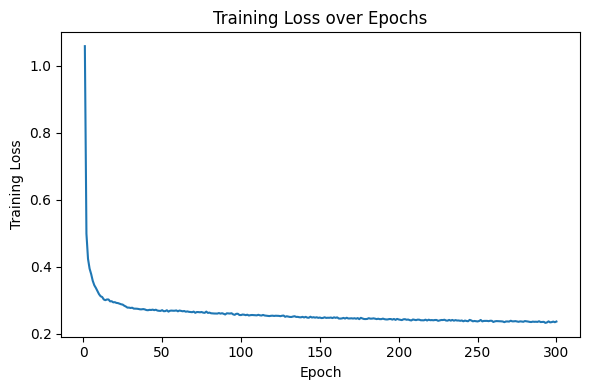

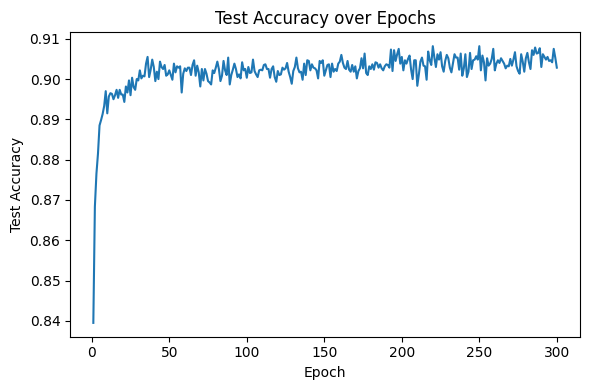

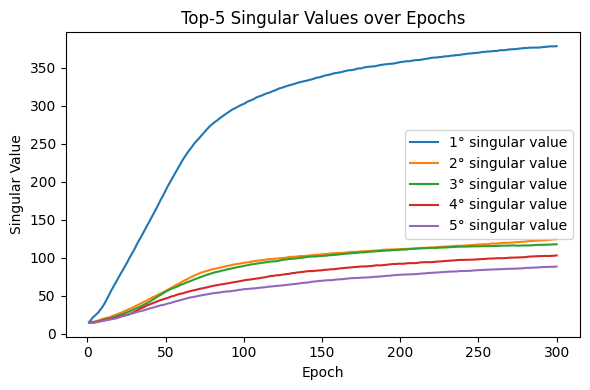

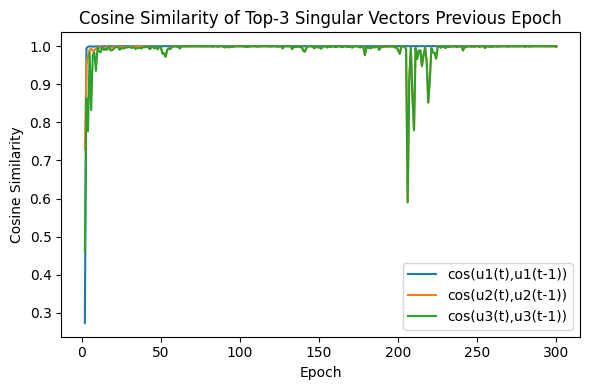

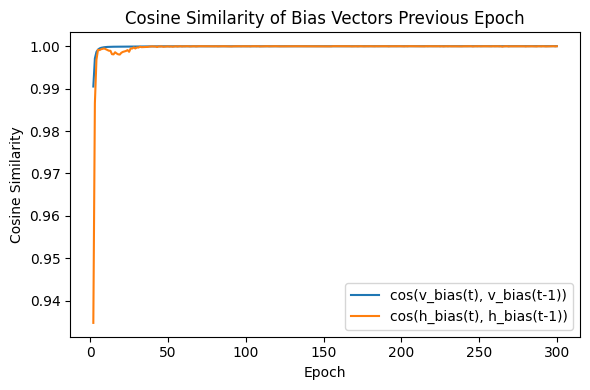

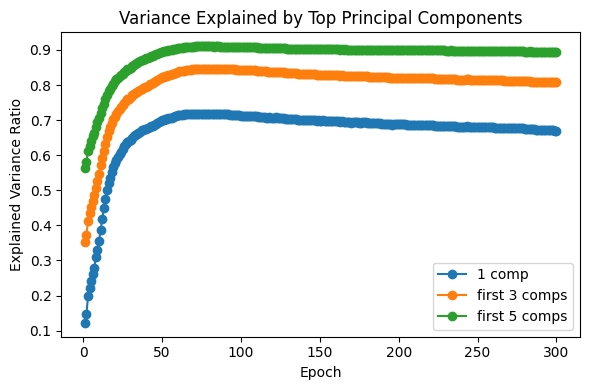

In [53]:
# ------------------------
# Training setup
# ------------------------
n_visible = 784
n_hidden  = 10
epochs    = 300
lr        = 0.01

rbm       = RBM(n_visible, n_hidden)
optimizer = torch.optim.Adam(rbm.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# storage
losses, accuracies = [], []
sv_lists = [ [] for _ in range(5) ]
cos_prev_lists = [ [] for _ in range(3) ]  # solo primi 3 autovettori
cos_b_list, cos_c_list = [], []
explained_1, explained_3, explained_5 = [], [], []
u_prev = [None]*3
b_prev_norm = None
c_prev_norm = None

epsilon = 1e-8

# ------------------------
# Training loop
# ------------------------
for epoch in range(1, epochs+1):
    # 1) CD update on full training tensor
    rbm.cd_step(X_train)
    optimizer.step()
    optimizer.zero_grad()

    # 2) Supervised classifier update
    total_loss = 0.0
    for xb, yb in train_loader:
        out  = rbm(xb)
        loss = criterion(out, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    losses.append(avg_loss)

    # 3) Evaluate on test set
    rbm.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            preds = rbm(xb).argmax(dim=1)
            all_preds.extend(preds.tolist())
            all_labels.extend(yb.tolist())
    acc = accuracy_score(all_labels, all_preds)
    accuracies.append(acc)

    # 4) Compute SVD of W
    with torch.no_grad():
        U, S, V = torch.svd(rbm.W)
    for i in range(5):
        sv_lists[i].append(S[i].item())

    # 5) Explained variance ratios
    sq = S**2
    total_var = sq.sum().item()
    explained_1.append(sq[0].item() / total_var)
    explained_3.append(sq[:3].sum().item() / total_var)
    explained_5.append(sq[:5].sum().item() / total_var)

    # 6) Cosine similarity with previous singular vectors (solo primi 3)
    for i in range(3):
        ui = U[:, i] / (U[:, i].norm() + epsilon)
        if u_prev[i] is not None:
            if torch.dot(u_prev[i], ui) < 0:
                ui = -ui
            cos_prev_lists[i].append(torch.dot(u_prev[i], ui).item())
        u_prev[i] = ui.clone()

    # 7) Cosine similarity for biases with stability fix
    b_curr = rbm.v_bias.detach()
    c_curr = rbm.h_bias.detach()
    b_norm = b_curr / (b_curr.norm() + epsilon)
    c_norm = c_curr / (c_curr.norm() + epsilon)
    if b_prev_norm is not None and c_prev_norm is not None:
        cos_b_list.append(torch.dot(b_prev_norm, b_norm).item())
        cos_c_list.append(torch.dot(c_prev_norm, c_norm).item())
    if b_curr.norm() > epsilon:
        b_prev_norm = b_norm.clone()
    if c_curr.norm() > epsilon:
        c_prev_norm = c_norm.clone()

# ------------------------
# Plot results
# ------------------------
epochs_range = np.arange(1, epochs+1)

plt.figure(figsize=(6,4))
plt.plot(epochs_range, losses)
plt.xlabel("Epoch"); plt.ylabel("Training Loss")
plt.title("Training Loss over Epochs")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs_range, accuracies)
plt.xlabel("Epoch"); plt.ylabel("Test Accuracy")
plt.title("Test Accuracy over Epochs")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
for i in range(5):
    plt.plot(epochs_range, sv_lists[i], label=f"{i+1}° singular value")
plt.xlabel("Epoch"); plt.ylabel("Singular Value")
plt.title("Top-5 Singular Values over Epochs")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
for i in range(3):  # solo primi 3
    plt.plot(np.arange(2, epochs+1), cos_prev_lists[i], label=f"cos(u{i+1}(t),u{i+1}(t-1))")
plt.xlabel("Epoch"); plt.ylabel("Cosine Similarity")
plt.title("Cosine Similarity of Top-3 Singular Vectors Previous Epoch")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(np.arange(2, epochs+1), cos_b_list, label="cos(v_bias(t), v_bias(t-1))")
plt.plot(np.arange(2, epochs+1), cos_c_list, label="cos(h_bias(t), h_bias(t-1))")
plt.xlabel("Epoch"); plt.ylabel("Cosine Similarity")
plt.title("Cosine Similarity of Bias Vectors Previous Epoch")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs_range, explained_1, '-o', label="1 comp")
plt.plot(epochs_range, explained_3, '-o', label="first 3 comps")
plt.plot(epochs_range, explained_5, '-o', label="first 5 comps")
plt.xlabel("Epoch"); plt.ylabel("Explained Variance Ratio")
plt.title("Variance Explained by Top Principal Components")
plt.legend(); plt.tight_layout(); plt.show()


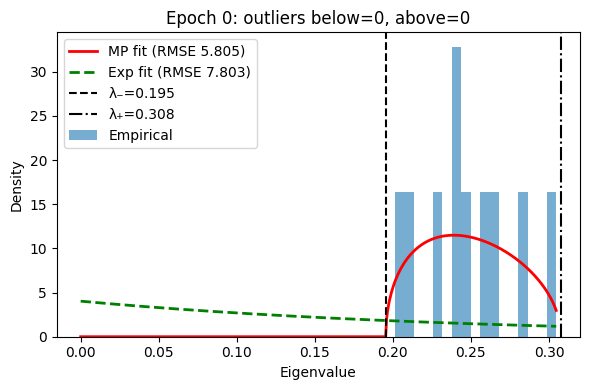

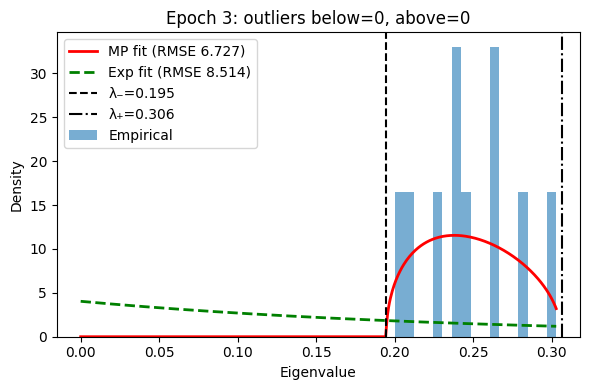

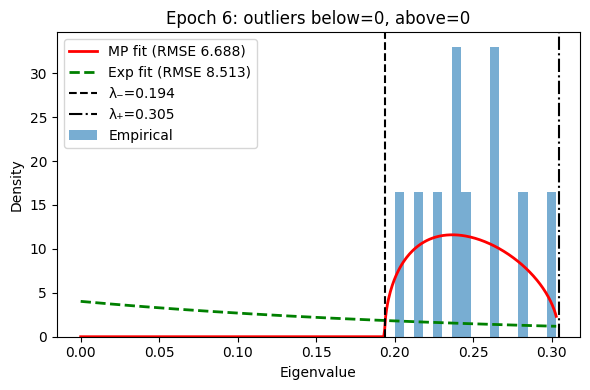

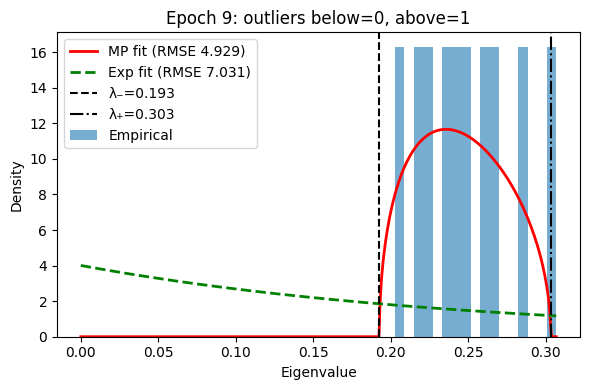

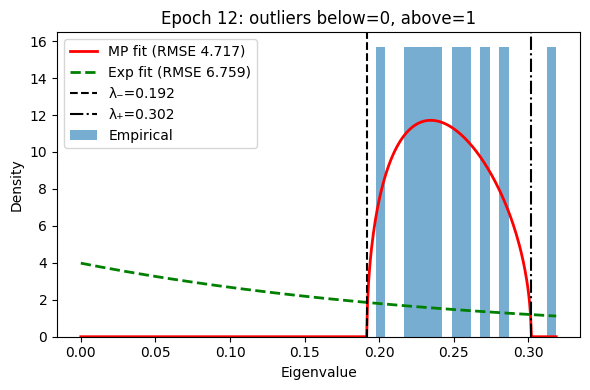

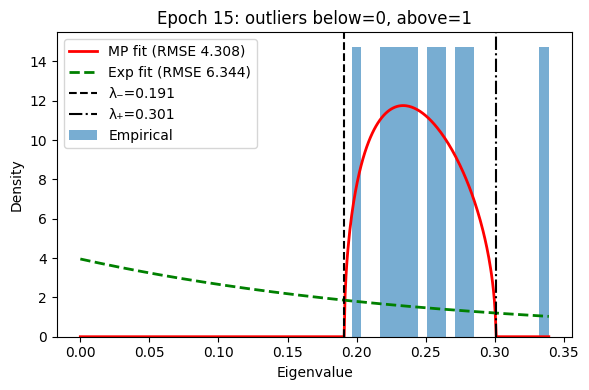

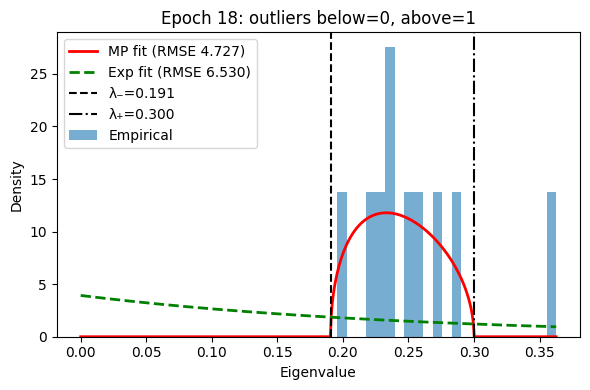

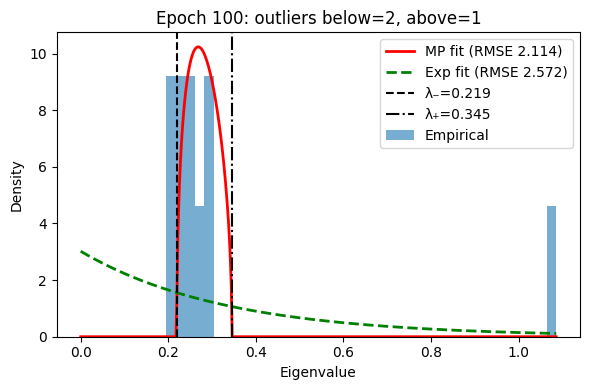

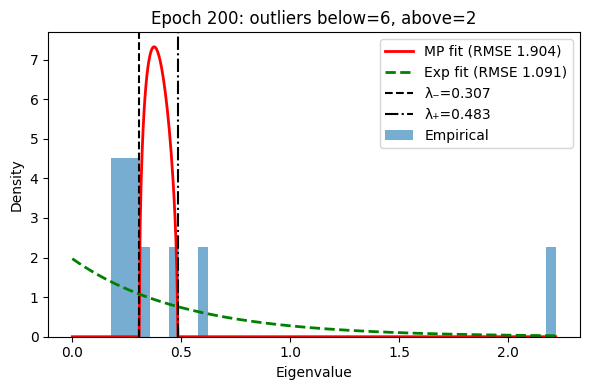

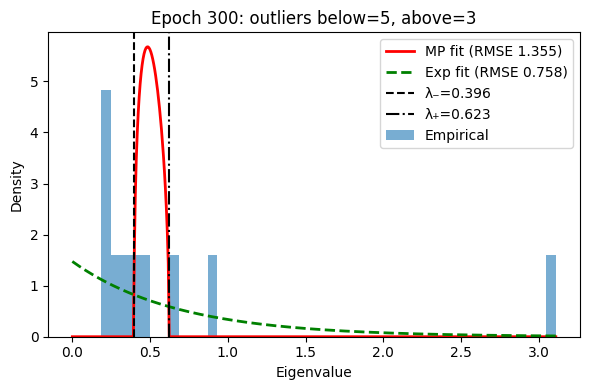

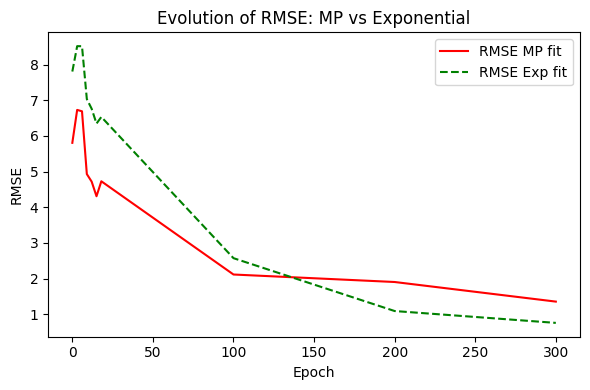

In [54]:
# ------------------------
# Training setup
# ------------------------
n_visible = 784
n_hidden  = 10
epochs    = 300
lr        = 0.01

rbm       = RBM(n_visible, n_hidden)
optimizer = torch.optim.Adam(rbm.parameters(), lr=lr)

# helper: Marchenko-Pastur PDF
def mp_pdf(x, sigma2, Q):
    lmin = sigma2 * (1 - np.sqrt(Q))**2
    lmax = sigma2 * (1 + np.sqrt(Q))**2
    pdf = np.zeros_like(x)
    mask = (x >= lmin) & (x <= lmax)
    pdf[mask] = np.sqrt((lmax - x[mask]) * (x[mask] - lmin)) / (2 * np.pi * sigma2 * Q * x[mask])
    return pdf, lmin, lmax

def should_plot(epoch):
    if epoch <= 20:
        return epoch % 3 == 0
    return epoch % 100 == 0

# storage for RMSE evolution
rmse_mp_list = []
rmse_exp_list = []
rmse_epochs = []

# ------------------------
# Plot before training (epoch 0)
# ------------------------
with torch.no_grad():
    W0 = rbm.W.detach().cpu().numpy()
sigma2_0 = W0.var()
Q = n_hidden / n_visible
C0 = (W0 @ W0.T) / n_visible

eigs0 = np.linalg.eigvalsh(C0)
hist0, bins0 = np.histogram(eigs0, bins=50, range=(0, eigs0.max()), density=True)
centers0 = 0.5 * (bins0[:-1] + bins0[1:])

xs0 = np.linspace(0, eigs0.max(), 500)
mp_vals0, lmin0, lmax0 = mp_pdf(xs0, sigma2_0, Q)

theta0 = eigs0.mean()
exp_vals0 = (1/theta0) * np.exp(-xs0/theta0)

mp_hist_vals0 = mp_pdf(centers0, sigma2_0, Q)[0]
exp_hist_vals0 = (1/theta0) * np.exp(-centers0/theta0)
rmse_mp_0 = np.sqrt(np.mean((hist0 - mp_hist_vals0)**2))
rmse_exp_0 = np.sqrt(np.mean((hist0 - exp_hist_vals0)**2))

rmse_mp_list.append(rmse_mp_0)
rmse_exp_list.append(rmse_exp_0)
rmse_epochs.append(0)

below0 = np.sum(eigs0 < lmin0)
above0 = np.sum(eigs0 > lmax0)

plt.figure(figsize=(6,4))
plt.bar(centers0, hist0, width=bins0[1]-bins0[0], alpha=0.6, label="Empirical")
plt.plot(xs0, mp_vals0, 'r-', lw=2, label=f"MP fit (RMSE {rmse_mp_0:.3f})")
plt.plot(xs0, exp_vals0, 'g--', lw=2, label=f"Exp fit (RMSE {rmse_exp_0:.3f})")
plt.axvline(lmin0, color='k', linestyle='--', label=f'λ₋={lmin0:.3f}')
plt.axvline(lmax0, color='k', linestyle='-.', label=f'λ₊={lmax0:.3f}')
plt.title(f"Epoch 0: outliers below={below0}, above={above0}")
plt.xlabel("Eigenvalue")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------
# Training loop with MP + exp plots
# ------------------------
for epoch in range(1, epochs+1):
    # CD update on full train set
    rbm.cd_step(X_train)
    optimizer.step()
    optimizer.zero_grad()

    # Plot MP & exponential fit at desired epochs
    if should_plot(epoch):
        W_np = rbm.W.detach().cpu().numpy()
        sigma2 = W_np.var()
        C = (W_np @ W_np.T) / n_visible

        eigs = np.linalg.eigvalsh(C)
        hist, bins = np.histogram(eigs, bins=50, range=(0, eigs.max()), density=True)
        centers = 0.5*(bins[:-1] + bins[1:])

        xs = np.linspace(0, eigs.max(), 500)
        mp_vals, lmin, lmax = mp_pdf(xs, sigma2, Q)

        theta = eigs.mean()
        exp_vals = (1/theta)*np.exp(-xs/theta)

        # RMSE on histogram centers
        mp_hist_vals = mp_pdf(centers, sigma2, Q)[0]
        exp_hist_vals = (1/theta)*np.exp(-centers/theta)
        rmse_mp = np.sqrt(np.mean((hist - mp_hist_vals)**2))
        rmse_exp = np.sqrt(np.mean((hist - exp_hist_vals)**2))

        rmse_mp_list.append(rmse_mp)
        rmse_exp_list.append(rmse_exp)
        rmse_epochs.append(epoch)

        below = np.sum(eigs < lmin)
        above = np.sum(eigs > lmax)

        plt.figure(figsize=(6,4))
        plt.bar(centers, hist, width=bins[1]-bins[0], alpha=0.6, label="Empirical")
        plt.plot(xs, mp_vals, 'r-', lw=2, label=f"MP fit (RMSE {rmse_mp:.3f})")
        plt.plot(xs, exp_vals, 'g--', lw=2, label=f"Exp fit (RMSE {rmse_exp:.3f})")
        plt.axvline(lmin, color='k', linestyle='--', label=f'λ₋={lmin:.3f}')
        plt.axvline(lmax, color='k', linestyle='-.', label=f'λ₊={lmax:.3f}')
        plt.title(f"Epoch {epoch}: outliers below={below}, above={above}")
        plt.xlabel("Eigenvalue")
        plt.ylabel("Density")
        plt.legend()
        plt.tight_layout()
        plt.show()

# ------------------------
# Final RMSE evolution plot
# ------------------------
plt.figure(figsize=(6,4))
plt.plot(rmse_epochs, rmse_mp_list, 'r-', label="RMSE MP fit")
plt.plot(rmse_epochs, rmse_exp_list, 'g--', label="RMSE Exp fit")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Evolution of RMSE: MP vs Exponential")
plt.legend()
plt.tight_layout()
plt.show()


100 HIDDEN NEURONS

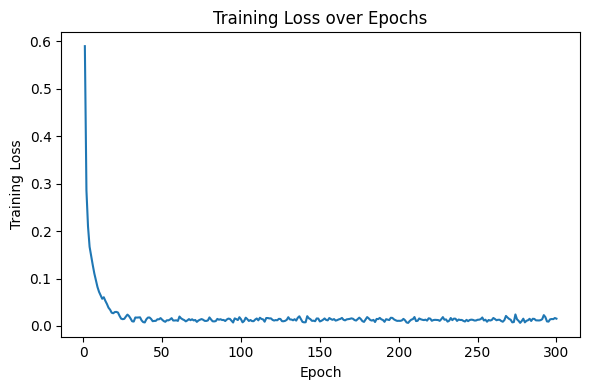

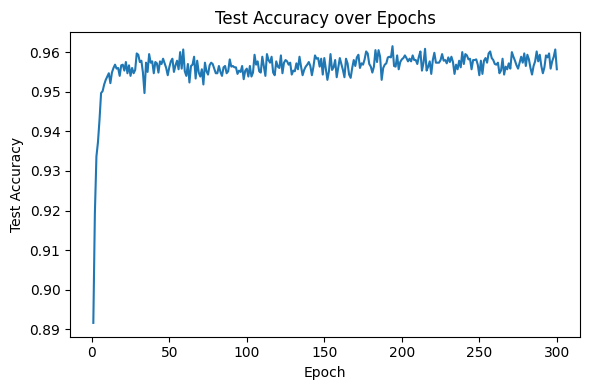

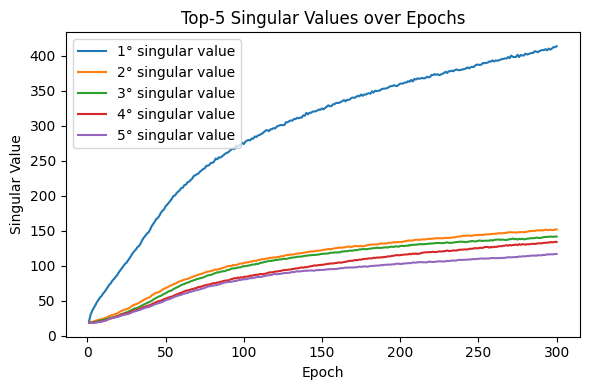

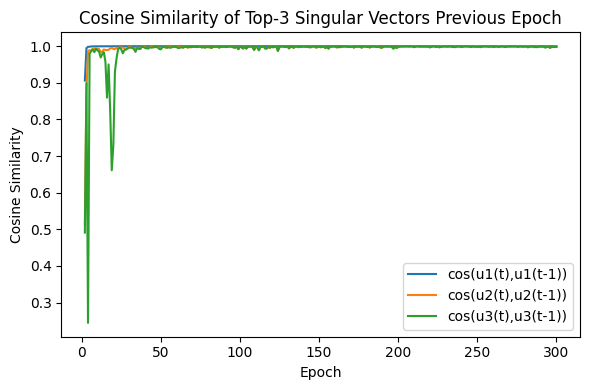

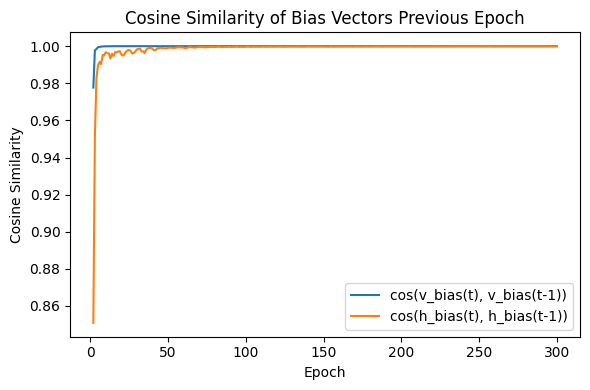

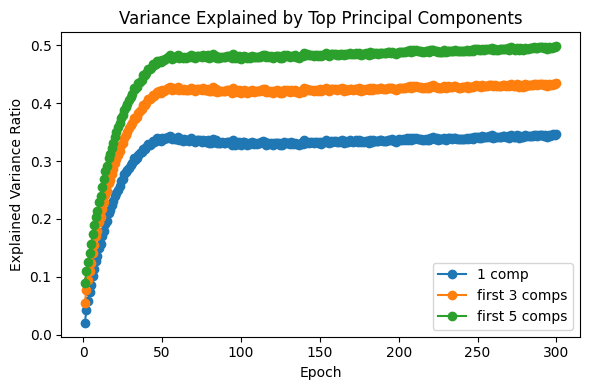

In [ ]:
# ------------------------
# Training setup
# ------------------------
n_visible = 784
n_hidden  = 100
epochs    = 300
lr        = 0.01

rbm       = RBM(n_visible, n_hidden)
optimizer = torch.optim.Adam(rbm.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# storage
losses, accuracies = [], []
sv_lists = [ [] for _ in range(5) ]
cos_prev_lists = [ [] for _ in range(3) ]  # solo primi 3 autovettori
cos_b_list, cos_c_list = [], []
explained_1, explained_3, explained_5 = [], [], []
u_prev = [None]*3
b_prev_norm = None
c_prev_norm = None

epsilon = 1e-8

# ------------------------
# Training loop
# ------------------------
for epoch in range(1, epochs+1):
    # 1) CD update on full training tensor
    rbm.cd_step(X_train)
    optimizer.step()
    optimizer.zero_grad()

    # 2) Supervised classifier update
    total_loss = 0.0
    for xb, yb in train_loader:
        out  = rbm(xb)
        loss = criterion(out, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    losses.append(avg_loss)

    # 3) Evaluate on test set
    rbm.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            preds = rbm(xb).argmax(dim=1)
            all_preds.extend(preds.tolist())
            all_labels.extend(yb.tolist())
    acc = accuracy_score(all_labels, all_preds)
    accuracies.append(acc)

    # 4) Compute SVD of W
    with torch.no_grad():
        U, S, V = torch.svd(rbm.W)
    for i in range(5):
        sv_lists[i].append(S[i].item())

    # 5) Explained variance ratios
    sq = S**2
    total_var = sq.sum().item()
    explained_1.append(sq[0].item() / total_var)
    explained_3.append(sq[:3].sum().item() / total_var)
    explained_5.append(sq[:5].sum().item() / total_var)

    # 6) Cosine similarity with previous singular vectors (solo primi 3)
    for i in range(3):
        ui = U[:, i] / (U[:, i].norm() + epsilon)
        if u_prev[i] is not None:
            if torch.dot(u_prev[i], ui) < 0:
                ui = -ui
            cos_prev_lists[i].append(torch.dot(u_prev[i], ui).item())
        u_prev[i] = ui.clone()

    # 7) Cosine similarity for biases with stability fix
    b_curr = rbm.v_bias.detach()
    c_curr = rbm.h_bias.detach()
    b_norm = b_curr / (b_curr.norm() + epsilon)
    c_norm = c_curr / (c_curr.norm() + epsilon)
    if b_prev_norm is not None and c_prev_norm is not None:
        cos_b_list.append(torch.dot(b_prev_norm, b_norm).item())
        cos_c_list.append(torch.dot(c_prev_norm, c_norm).item())
    if b_curr.norm() > epsilon:
        b_prev_norm = b_norm.clone()
    if c_curr.norm() > epsilon:
        c_prev_norm = c_norm.clone()

# ------------------------
# Plot results
# ------------------------
epochs_range = np.arange(1, epochs+1)

plt.figure(figsize=(6,4))
plt.plot(epochs_range, losses)
plt.xlabel("Epoch"); plt.ylabel("Training Loss")
plt.title("Training Loss over Epochs")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs_range, accuracies)
plt.xlabel("Epoch"); plt.ylabel("Test Accuracy")
plt.title("Test Accuracy over Epochs")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
for i in range(5):
    plt.plot(epochs_range, sv_lists[i], label=f"{i+1}° singular value")
plt.xlabel("Epoch"); plt.ylabel("Singular Value")
plt.title("Top-5 Singular Values over Epochs")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
for i in range(3):  # solo primi 3
    plt.plot(np.arange(2, epochs+1), cos_prev_lists[i], label=f"cos(u{i+1}(t),u{i+1}(t-1))")
plt.xlabel("Epoch"); plt.ylabel("Cosine Similarity")
plt.title("Cosine Similarity of Top-3 Singular Vectors Previous Epoch")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(np.arange(2, epochs+1), cos_b_list, label="cos(v_bias(t), v_bias(t-1))")
plt.plot(np.arange(2, epochs+1), cos_c_list, label="cos(h_bias(t), h_bias(t-1))")
plt.xlabel("Epoch"); plt.ylabel("Cosine Similarity")
plt.title("Cosine Similarity of Bias Vectors Previous Epoch")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs_range, explained_1, '-o', label="1 comp")
plt.plot(epochs_range, explained_3, '-o', label="first 3 comps")
plt.plot(epochs_range, explained_5, '-o', label="first 5 comps")
plt.xlabel("Epoch"); plt.ylabel("Explained Variance Ratio")
plt.title("Variance Explained by Top Principal Components")
plt.legend(); plt.tight_layout(); plt.show()


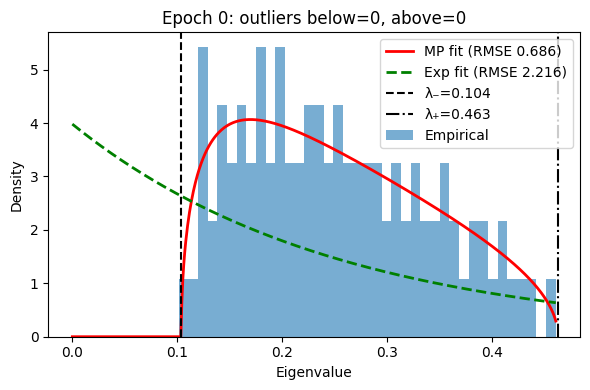

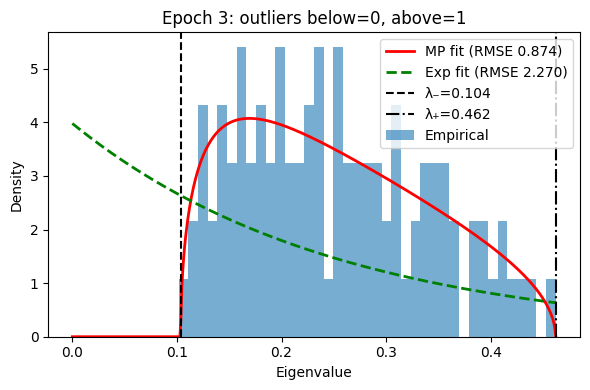

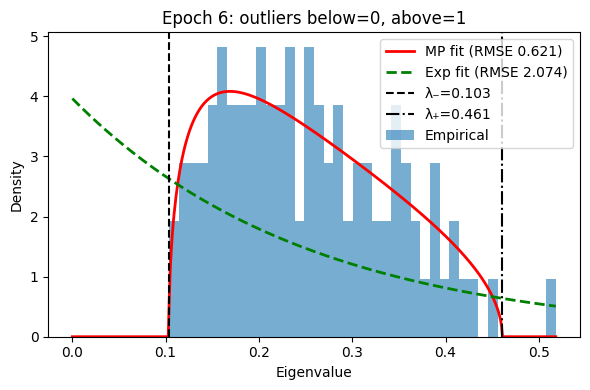

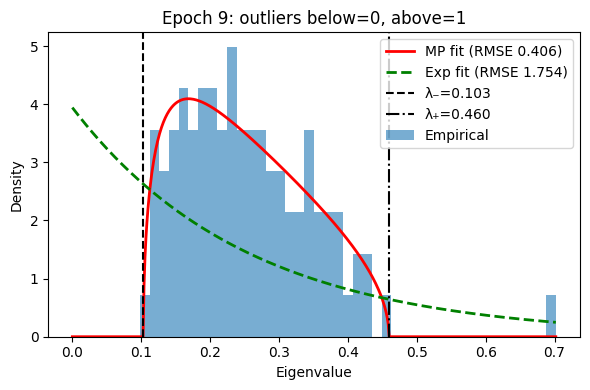

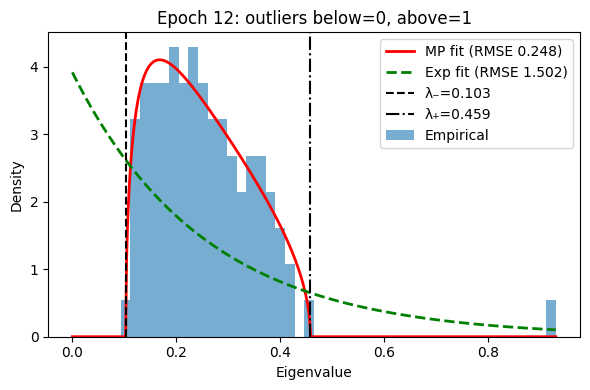

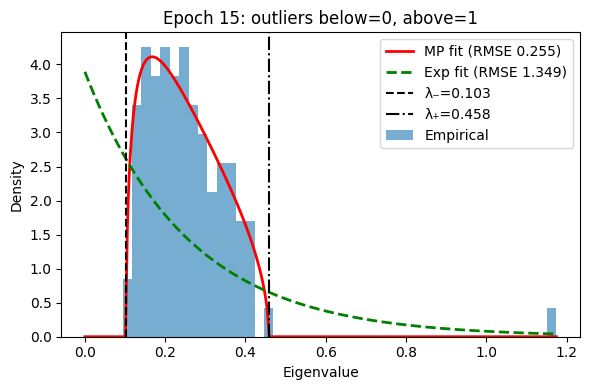

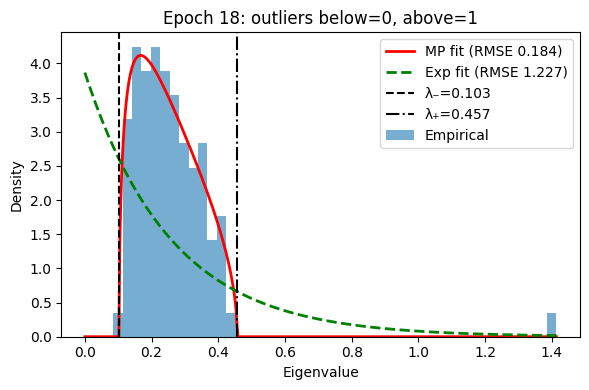

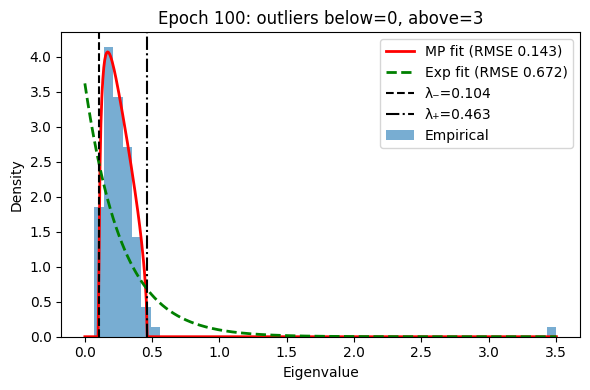

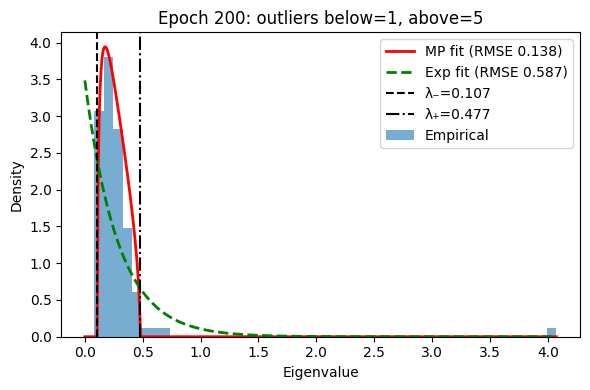

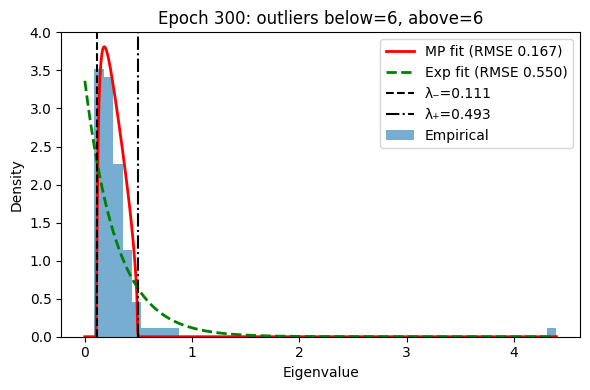

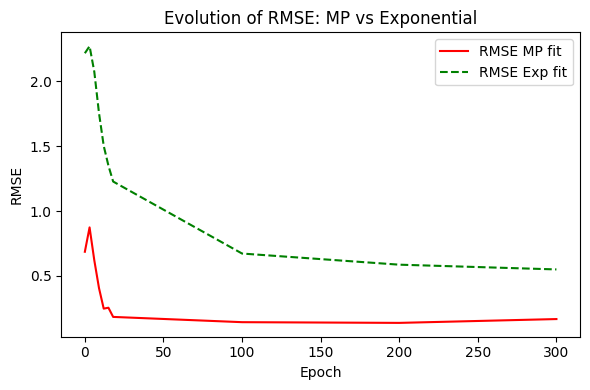

In [61]:
# ------------------------
# Training setup
# ------------------------
n_visible = 784
n_hidden  = 100
epochs    = 300
lr        = 0.01

rbm       = RBM(n_visible, n_hidden)
optimizer = torch.optim.Adam(rbm.parameters(), lr=lr)

# helper: Marchenko-Pastur PDF
def mp_pdf(x, sigma2, Q):
    lmin = sigma2 * (1 - np.sqrt(Q))**2
    lmax = sigma2 * (1 + np.sqrt(Q))**2
    pdf = np.zeros_like(x)
    mask = (x >= lmin) & (x <= lmax)
    pdf[mask] = np.sqrt((lmax - x[mask]) * (x[mask] - lmin)) / (2 * np.pi * sigma2 * Q * x[mask])
    return pdf, lmin, lmax

def should_plot(epoch):
    if epoch <= 20:
        return epoch % 3 == 0
    return epoch % 100 == 0

# storage for RMSE evolution
rmse_mp_list = []
rmse_exp_list = []
rmse_epochs = []

# ------------------------
# Plot before training (epoch 0)
# ------------------------
with torch.no_grad():
    W0 = rbm.W.detach().cpu().numpy()
sigma2_0 = W0.var()
Q = n_hidden / n_visible
C0 = (W0 @ W0.T) / n_visible

eigs0 = np.linalg.eigvalsh(C0)
hist0, bins0 = np.histogram(eigs0, bins=50, range=(0, eigs0.max()), density=True)
centers0 = 0.5 * (bins0[:-1] + bins0[1:])

xs0 = np.linspace(0, eigs0.max(), 500)
mp_vals0, lmin0, lmax0 = mp_pdf(xs0, sigma2_0, Q)

theta0 = eigs0.mean()
exp_vals0 = (1/theta0) * np.exp(-xs0/theta0)

mp_hist_vals0 = mp_pdf(centers0, sigma2_0, Q)[0]
exp_hist_vals0 = (1/theta0) * np.exp(-centers0/theta0)
rmse_mp_0 = np.sqrt(np.mean((hist0 - mp_hist_vals0)**2))
rmse_exp_0 = np.sqrt(np.mean((hist0 - exp_hist_vals0)**2))

rmse_mp_list.append(rmse_mp_0)
rmse_exp_list.append(rmse_exp_0)
rmse_epochs.append(0)

below0 = np.sum(eigs0 < lmin0)
above0 = np.sum(eigs0 > lmax0)

plt.figure(figsize=(6,4))
plt.bar(centers0, hist0, width=bins0[1]-bins0[0], alpha=0.6, label="Empirical")
plt.plot(xs0, mp_vals0, 'r-', lw=2, label=f"MP fit (RMSE {rmse_mp_0:.3f})")
plt.plot(xs0, exp_vals0, 'g--', lw=2, label=f"Exp fit (RMSE {rmse_exp_0:.3f})")
plt.axvline(lmin0, color='k', linestyle='--', label=f'λ₋={lmin0:.3f}')
plt.axvline(lmax0, color='k', linestyle='-.', label=f'λ₊={lmax0:.3f}')
plt.title(f"Epoch 0: outliers below={below0}, above={above0}")
plt.xlabel("Eigenvalue")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------
# Training loop with MP + exp plots
# ------------------------
for epoch in range(1, epochs+1):
    # CD update on full train set
    rbm.cd_step(X_train)
    optimizer.step()
    optimizer.zero_grad()

    # Plot MP & exponential fit at desired epochs
    if should_plot(epoch):
        W_np = rbm.W.detach().cpu().numpy()
        sigma2 = W_np.var()
        C = (W_np @ W_np.T) / n_visible

        eigs = np.linalg.eigvalsh(C)
        hist, bins = np.histogram(eigs, bins=50, range=(0, eigs.max()), density=True)
        centers = 0.5*(bins[:-1] + bins[1:])

        xs = np.linspace(0, eigs.max(), 500)
        mp_vals, lmin, lmax = mp_pdf(xs, sigma2, Q)

        theta = eigs.mean()
        exp_vals = (1/theta)*np.exp(-xs/theta)

        # RMSE on histogram centers
        mp_hist_vals = mp_pdf(centers, sigma2, Q)[0]
        exp_hist_vals = (1/theta)*np.exp(-centers/theta)
        rmse_mp = np.sqrt(np.mean((hist - mp_hist_vals)**2))
        rmse_exp = np.sqrt(np.mean((hist - exp_hist_vals)**2))

        rmse_mp_list.append(rmse_mp)
        rmse_exp_list.append(rmse_exp)
        rmse_epochs.append(epoch)

        below = np.sum(eigs < lmin)
        above = np.sum(eigs > lmax)

        plt.figure(figsize=(6,4))
        plt.bar(centers, hist, width=bins[1]-bins[0], alpha=0.6, label="Empirical")
        plt.plot(xs, mp_vals, 'r-', lw=2, label=f"MP fit (RMSE {rmse_mp:.3f})")
        plt.plot(xs, exp_vals, 'g--', lw=2, label=f"Exp fit (RMSE {rmse_exp:.3f})")
        plt.axvline(lmin, color='k', linestyle='--', label=f'λ₋={lmin:.3f}')
        plt.axvline(lmax, color='k', linestyle='-.', label=f'λ₊={lmax:.3f}')
        plt.title(f"Epoch {epoch}: outliers below={below}, above={above}")
        plt.xlabel("Eigenvalue")
        plt.ylabel("Density")
        plt.legend()
        plt.tight_layout()
        plt.show()

# ------------------------
# Final RMSE evolution plot
# ------------------------
plt.figure(figsize=(6,4))
plt.plot(rmse_epochs, rmse_mp_list, 'r-', label="RMSE MP fit")
plt.plot(rmse_epochs, rmse_exp_list, 'g--', label="RMSE Exp fit")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Evolution of RMSE: MP vs Exponential")
plt.legend()
plt.tight_layout()
plt.show()


1000 HIDDEN NEURONS

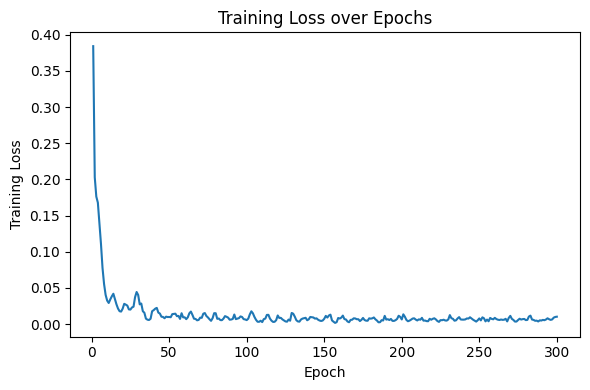

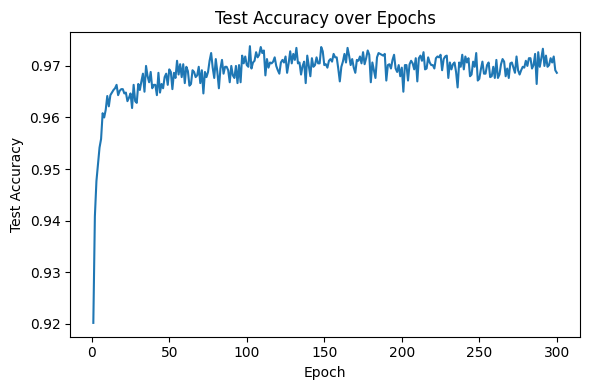

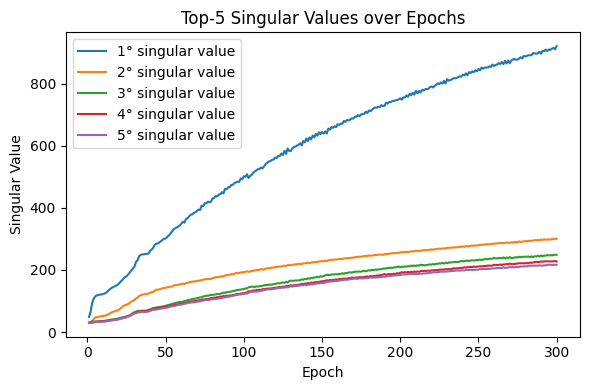

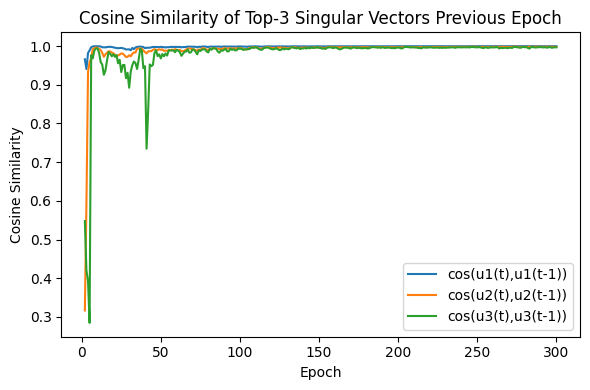

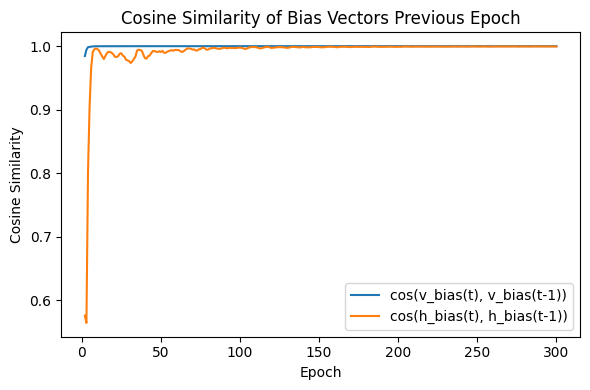

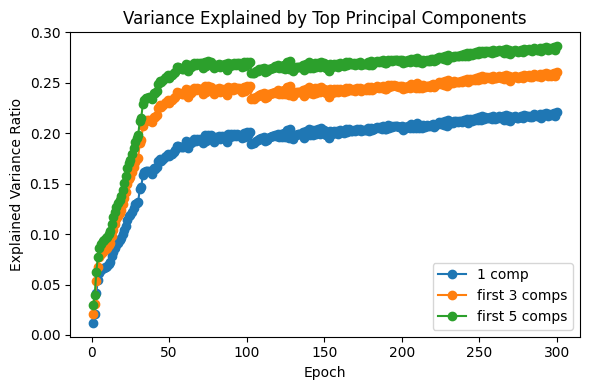

In [57]:
# ------------------------
# Training setup
# ------------------------
n_visible = 784
n_hidden  = 1000
epochs    = 300
lr        = 0.01

rbm       = RBM(n_visible, n_hidden)
optimizer = torch.optim.Adam(rbm.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# storage
losses, accuracies = [], []
sv_lists = [ [] for _ in range(5) ]
cos_prev_lists = [ [] for _ in range(3) ]  # solo primi 3 autovettori
cos_b_list, cos_c_list = [], []
explained_1, explained_3, explained_5 = [], [], []
u_prev = [None]*3
b_prev_norm = None
c_prev_norm = None

epsilon = 1e-8

# ------------------------
# Training loop
# ------------------------
for epoch in range(1, epochs+1):
    # 1) CD update on full training tensor
    rbm.cd_step(X_train)
    optimizer.step()
    optimizer.zero_grad()

    # 2) Supervised classifier update
    total_loss = 0.0
    for xb, yb in train_loader:
        out  = rbm(xb)
        loss = criterion(out, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    losses.append(avg_loss)

    # 3) Evaluate on test set
    rbm.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            preds = rbm(xb).argmax(dim=1)
            all_preds.extend(preds.tolist())
            all_labels.extend(yb.tolist())
    acc = accuracy_score(all_labels, all_preds)
    accuracies.append(acc)

    # 4) Compute SVD of W
    with torch.no_grad():
        U, S, V = torch.svd(rbm.W)
    for i in range(5):
        sv_lists[i].append(S[i].item())

    # 5) Explained variance ratios
    sq = S**2
    total_var = sq.sum().item()
    explained_1.append(sq[0].item() / total_var)
    explained_3.append(sq[:3].sum().item() / total_var)
    explained_5.append(sq[:5].sum().item() / total_var)

    # 6) Cosine similarity with previous singular vectors (solo primi 3)
    for i in range(3):
        ui = U[:, i] / (U[:, i].norm() + epsilon)
        if u_prev[i] is not None:
            if torch.dot(u_prev[i], ui) < 0:
                ui = -ui
            cos_prev_lists[i].append(torch.dot(u_prev[i], ui).item())
        u_prev[i] = ui.clone()

    # 7) Cosine similarity for biases with stability fix
    b_curr = rbm.v_bias.detach()
    c_curr = rbm.h_bias.detach()
    b_norm = b_curr / (b_curr.norm() + epsilon)
    c_norm = c_curr / (c_curr.norm() + epsilon)
    if b_prev_norm is not None and c_prev_norm is not None:
        cos_b_list.append(torch.dot(b_prev_norm, b_norm).item())
        cos_c_list.append(torch.dot(c_prev_norm, c_norm).item())
    if b_curr.norm() > epsilon:
        b_prev_norm = b_norm.clone()
    if c_curr.norm() > epsilon:
        c_prev_norm = c_norm.clone()

# ------------------------
# Plot results
# ------------------------
epochs_range = np.arange(1, epochs+1)

plt.figure(figsize=(6,4))
plt.plot(epochs_range, losses)
plt.xlabel("Epoch"); plt.ylabel("Training Loss")
plt.title("Training Loss over Epochs")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs_range, accuracies)
plt.xlabel("Epoch"); plt.ylabel("Test Accuracy")
plt.title("Test Accuracy over Epochs")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
for i in range(5):
    plt.plot(epochs_range, sv_lists[i], label=f"{i+1}° singular value")
plt.xlabel("Epoch"); plt.ylabel("Singular Value")
plt.title("Top-5 Singular Values over Epochs")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
for i in range(3):  # solo primi 3
    plt.plot(np.arange(2, epochs+1), cos_prev_lists[i], label=f"cos(u{i+1}(t),u{i+1}(t-1))")
plt.xlabel("Epoch"); plt.ylabel("Cosine Similarity")
plt.title("Cosine Similarity of Top-3 Singular Vectors Previous Epoch")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(np.arange(2, epochs+1), cos_b_list, label="cos(v_bias(t), v_bias(t-1))")
plt.plot(np.arange(2, epochs+1), cos_c_list, label="cos(h_bias(t), h_bias(t-1))")
plt.xlabel("Epoch"); plt.ylabel("Cosine Similarity")
plt.title("Cosine Similarity of Bias Vectors Previous Epoch")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs_range, explained_1, '-o', label="1 comp")
plt.plot(epochs_range, explained_3, '-o', label="first 3 comps")
plt.plot(epochs_range, explained_5, '-o', label="first 5 comps")
plt.xlabel("Epoch"); plt.ylabel("Explained Variance Ratio")
plt.title("Variance Explained by Top Principal Components")
plt.legend(); plt.tight_layout(); plt.show()


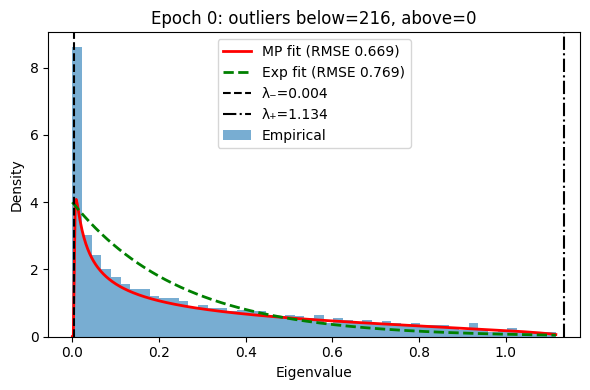

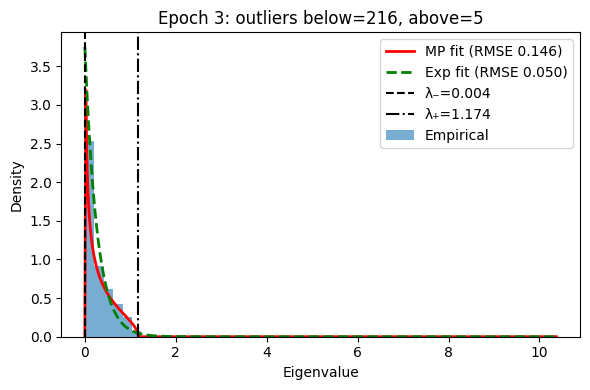

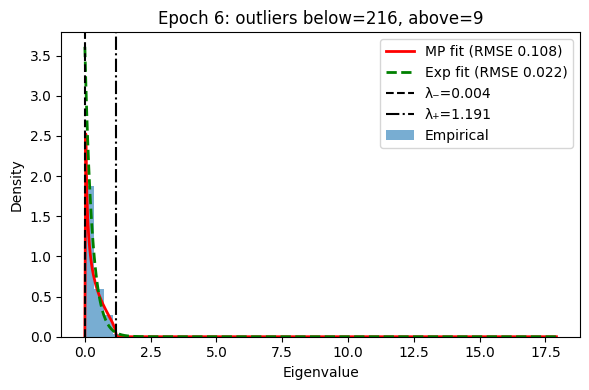

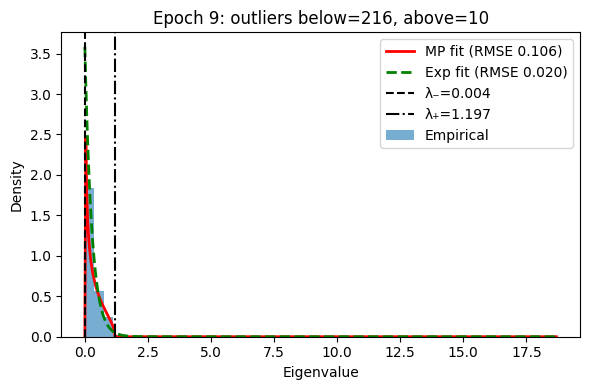

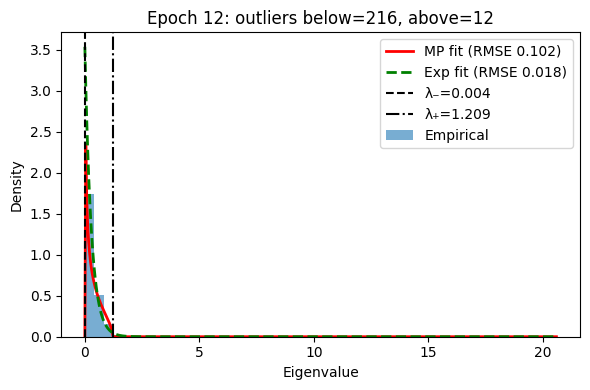

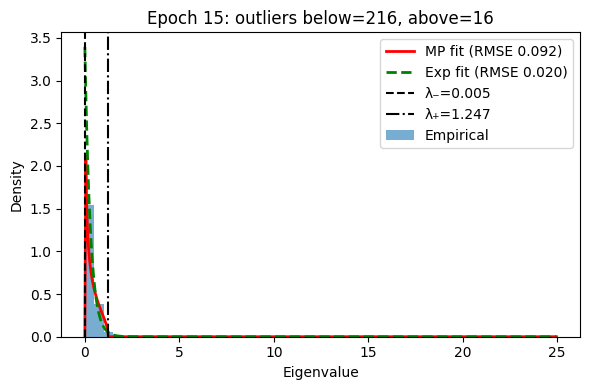

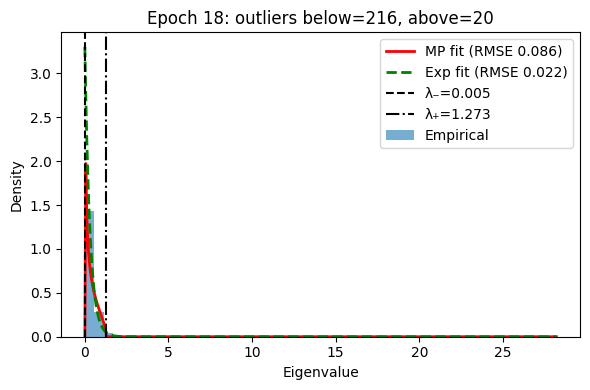

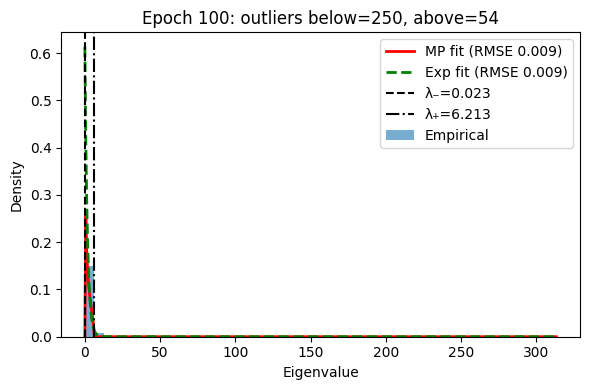

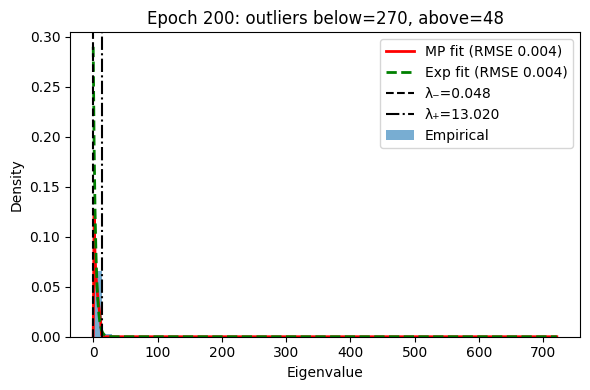

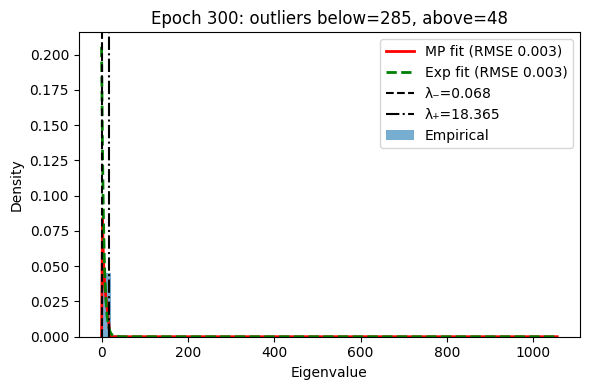

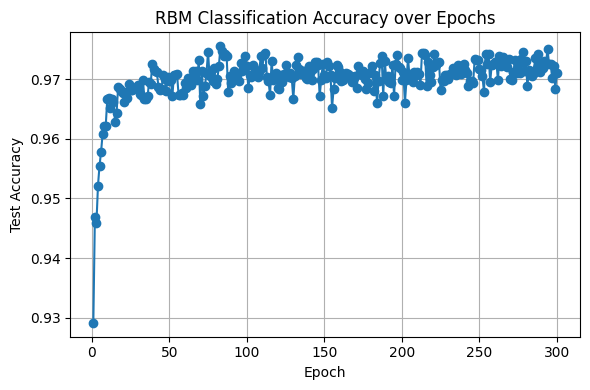

Final test accuracy: 0.9710


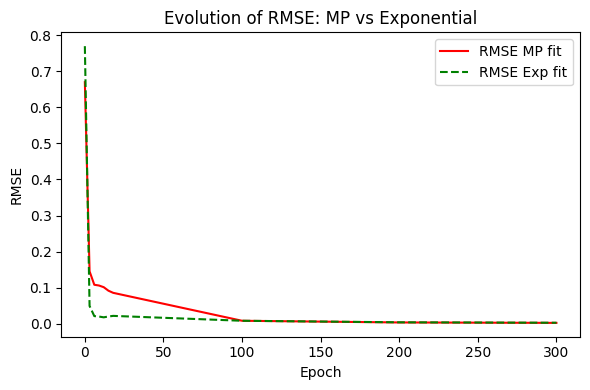

In [62]:
# ------------------------
# Training setup
# ------------------------
n_visible = 784
n_hidden  = 1000
epochs    = 300
lr        = 0.01

rbm       = RBM(n_visible, n_hidden)
optimizer = torch.optim.Adam(rbm.parameters(), lr=lr)

# helper: Marchenko-Pastur PDF
def mp_pdf(x, sigma2, Q):
    lmin = sigma2 * (1 - np.sqrt(Q))**2
    lmax = sigma2 * (1 + np.sqrt(Q))**2
    pdf = np.zeros_like(x)
    mask = (x >= lmin) & (x <= lmax)
    pdf[mask] = np.sqrt((lmax - x[mask]) * (x[mask] - lmin)) / (2 * np.pi * sigma2 * Q * x[mask])
    return pdf, lmin, lmax

def should_plot(epoch):
    if epoch <= 20:
        return epoch % 3 == 0
    return epoch % 100 == 0

# storage for RMSE evolution
rmse_mp_list = []
rmse_exp_list = []
rmse_epochs = []

# ------------------------
# Plot before training (epoch 0)
# ------------------------
with torch.no_grad():
    W0 = rbm.W.detach().cpu().numpy()
sigma2_0 = W0.var()
Q = n_hidden / n_visible
C0 = (W0 @ W0.T) / n_visible

eigs0 = np.linalg.eigvalsh(C0)
hist0, bins0 = np.histogram(eigs0, bins=50, range=(0, eigs0.max()), density=True)
centers0 = 0.5 * (bins0[:-1] + bins0[1:])

xs0 = np.linspace(0, eigs0.max(), 500)
mp_vals0, lmin0, lmax0 = mp_pdf(xs0, sigma2_0, Q)

theta0 = eigs0.mean()
exp_vals0 = (1/theta0) * np.exp(-xs0/theta0)

mp_hist_vals0 = mp_pdf(centers0, sigma2_0, Q)[0]
exp_hist_vals0 = (1/theta0) * np.exp(-centers0/theta0)
rmse_mp_0 = np.sqrt(np.mean((hist0 - mp_hist_vals0)**2))
rmse_exp_0 = np.sqrt(np.mean((hist0 - exp_hist_vals0)**2))

rmse_mp_list.append(rmse_mp_0)
rmse_exp_list.append(rmse_exp_0)
rmse_epochs.append(0)

below0 = np.sum(eigs0 < lmin0)
above0 = np.sum(eigs0 > lmax0)

plt.figure(figsize=(6,4))
plt.bar(centers0, hist0, width=bins0[1]-bins0[0], alpha=0.6, label="Empirical")
plt.plot(xs0, mp_vals0, 'r-', lw=2, label=f"MP fit (RMSE {rmse_mp_0:.3f})")
plt.plot(xs0, exp_vals0, 'g--', lw=2, label=f"Exp fit (RMSE {rmse_exp_0:.3f})")
plt.axvline(lmin0, color='k', linestyle='--', label=f'λ₋={lmin0:.3f}')
plt.axvline(lmax0, color='k', linestyle='-.', label=f'λ₊={lmax0:.3f}')
plt.title(f"Epoch 0: outliers below={below0}, above={above0}")
plt.xlabel("Eigenvalue")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------
# Training loop with MP + exp plots
# ------------------------
accuracies = []

for epoch in range(1, epochs+1):
    # 1. CD (unsupervised) update
    rbm.cd_step(X_train)
    optimizer.step()
    optimizer.zero_grad()

    # 2. Supervised update (classifier)
    total_loss = 0.0
    for xb, yb in train_loader:
        out = rbm(xb)
        loss = criterion(out, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_loader.dataset)

    # 3. Evaluate accuracy on test set
    rbm.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            preds = rbm(xb).argmax(dim=1)
            all_preds.extend(preds.tolist())
            all_labels.extend(yb.tolist())
    acc = accuracy_score(all_labels, all_preds)
    accuracies.append(acc)


    # Plot MP & exponential fit at desired epochs
    if should_plot(epoch):
        W_np = rbm.W.detach().cpu().numpy()
        sigma2 = W_np.var()
        C = (W_np @ W_np.T) / n_visible

        eigs = np.linalg.eigvalsh(C)
        hist, bins = np.histogram(eigs, bins=50, range=(0, eigs.max()), density=True)
        centers = 0.5*(bins[:-1] + bins[1:])

        xs = np.linspace(0, eigs.max(), 500)
        mp_vals, lmin, lmax = mp_pdf(xs, sigma2, Q)

        theta = eigs.mean()
        exp_vals = (1/theta)*np.exp(-xs/theta)

        # RMSE on histogram centers
        mp_hist_vals = mp_pdf(centers, sigma2, Q)[0]
        exp_hist_vals = (1/theta)*np.exp(-centers/theta)
        rmse_mp = np.sqrt(np.mean((hist - mp_hist_vals)**2))
        rmse_exp = np.sqrt(np.mean((hist - exp_hist_vals)**2))

        rmse_mp_list.append(rmse_mp)
        rmse_exp_list.append(rmse_exp)
        rmse_epochs.append(epoch)

        below = np.sum(eigs < lmin)
        above = np.sum(eigs > lmax)

        plt.figure(figsize=(6,4))
        plt.bar(centers, hist, width=bins[1]-bins[0], alpha=0.6, label="Empirical")
        plt.plot(xs, mp_vals, 'r-', lw=2, label=f"MP fit (RMSE {rmse_mp:.3f})")
        plt.plot(xs, exp_vals, 'g--', lw=2, label=f"Exp fit (RMSE {rmse_exp:.3f})")
        plt.axvline(lmin, color='k', linestyle='--', label=f'λ₋={lmin:.3f}')
        plt.axvline(lmax, color='k', linestyle='-.', label=f'λ₊={lmax:.3f}')
        plt.title(f"Epoch {epoch}: outliers below={below}, above={above}")
        plt.xlabel("Eigenvalue")
        plt.ylabel("Density")
        plt.legend()
        plt.tight_layout()
        plt.show()

# ------------------------
# Plot test accuracy over epochs
# ------------------------
plt.figure(figsize=(6,4))
plt.plot(range(1, epochs+1), accuracies, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title("RBM Classification Accuracy over Epochs")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Final test accuracy: {accuracies[-1]:.4f}")


# ------------------------
# Final RMSE evolution plot
# ------------------------
plt.figure(figsize=(6,4))
plt.plot(rmse_epochs, rmse_mp_list, 'r-', label="RMSE MP fit")
plt.plot(rmse_epochs, rmse_exp_list, 'g--', label="RMSE Exp fit")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Evolution of RMSE: MP vs Exponential")
plt.legend()
plt.tight_layout()
plt.show()


REDUCE THE WEIGHT MATRIX WITH PCA BASED ON THE EIGENVALUES UNDER THE BULK

n_hidden reduced = 715 (1000 - 285)


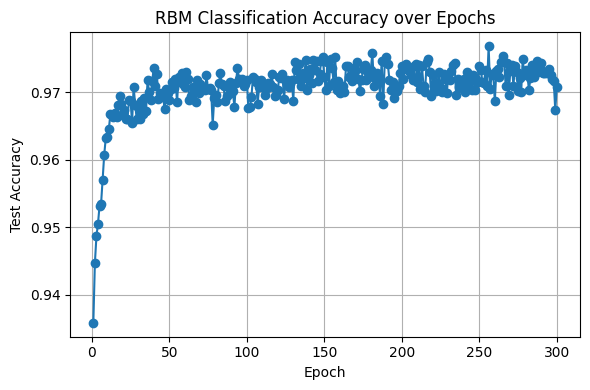

Final test accuracy: 0.9708


In [65]:
# ------------------------
# Training setup
# ------------------------

n_visible = 784
n_hidden_reduced = 1000 - below
epochs    = 300
lr        = 0.01

print(f"n_hidden reduced = {n_hidden_reduced} (1000 - {below})")

rbm       = RBM(n_visible, n_hidden)
optimizer = torch.optim.Adam(rbm.parameters(), lr=lr)
# ------------------------
# Training loop with accuracy tracking
# ------------------------
accuracies = []

for epoch in range(1, epochs+1):
    # 1. CD (unsupervised) update
    rbm.cd_step(X_train)
    optimizer.step()
    optimizer.zero_grad()

    # 2. Supervised update (classifier)
    total_loss = 0.0
    for xb, yb in train_loader:
        out = rbm(xb)
        loss = criterion(out, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_loader.dataset)

    # 3. Evaluate accuracy on test set
    rbm.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            preds = rbm(xb).argmax(dim=1)
            all_preds.extend(preds.tolist())
            all_labels.extend(yb.tolist())
    acc = accuracy_score(all_labels, all_preds)
    accuracies.append(acc)

# ------------------------
# Plot test accuracy over epochs
# ------------------------
plt.figure(figsize=(6,4))
plt.plot(range(1, epochs+1), accuracies, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title("RBM Classification Accuracy over Epochs")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Final test accuracy: {accuracies[-1]:.4f}")

